# Job Timing Study
This notebook is for studying the behavior of jobs using the new condor installation on the new cluster.

### Goals
- Determine a good user configuration of job clusters
- Understand condor configuration variables

The condor configuration variables that configure file transfer are listed below. Their names and descriptions are simply copied from the [documentation](https://htcondor.readthedocs.io/en/latest/admin-manual/configuration-macros.html#condor-master-configuration-file-macros).

- `MAX_CONCURRENT_DOWNLOADS` : absolute max of simultaneous transfers of output files from execute machines to submit machine
- `MAX_CONCURRENT_UPLOADS` : absolute max of simultaneous transfers of input files from submit machine to execute machines
- `FILE_TRANSFER_DISK_LOAD_THROTTLE` : disk load triggering throttling
    - disk load is calculated as the average number of simultaneous read/write operations (the averaging time is specified by other parameters that we avoid modifying)
    - throttling dynamically decreases the allowed number of concurrent uploads and downloads
    - two parameters defined: upper and lower limit. When disk load is above upper limit, no new transfers can be started. When disk load is between, new transfers are only started to replace completed ones. When below lower limit, transfers up to absolute maxima are allowed

### Requirements
- htcondor : Python API for interacting with HTCondor
- Run on spa-osg-login (or whereever jobs are submitted from) so we can acquire the job history
- pandas and matplotlib for analysis

In [25]:
import htcondor
import classad
import pandas as pd
import matplotlib.pyplot as plt

def acquire_timing(constraint) :
    """Acquire timing data from jobs matching the input constraint
    
    A constraint is following HTCondor's classad API. For example,
    a simple constraint would be matching a specific cluster ID from
    the past.
    
        classad.Attribute('ClusterId') == 420
        
    After acquiring the raw timing data from the condor schedd,
    we add a few more columns to the data frame with variables of interest.
    
    - 'JobTime' : difference between output transfer complete and job start
        (not perfectly equal to total job time but within a few seconds)
    - 'Transfer{In,Out}' : time [s] spent actually copying data in/out
    - 'FracTransfer{In,Out}' : fraction of job time spent copying data in/out
    - 'Trasnfer{In,Out}QueueTime' : time [s] job spent in queue to copy data in/out
    """
    
    items_of_interest = {
        'ClusterId' : [],
        'ProcId' : [],
        'ExitCode' : [],
        'TransferInputSizeMB' : [],
        'JobStartDate' : [],
        'TransferInQueued' : [],
        'TransferInStarted' : [],
        'TransferInFinished' : [],
        'TransferOutQueued' : [],
        'TransferOutStarted' : [],
        'TransferOutFinished' : []
    }
    schedd = htcondor.Schedd()
    for h in schedd.history(constraint,list(items_of_interest.keys())) :
        for k in items_of_interest :
            items_of_interest[k].append(h.get(k))

    df = pd.DataFrame(items_of_interest)
    df['JobTime'] = df['TransferOutFinished']-df['JobStartDate']
    for d in ['In','Out'] :
        df[f'Transfer{d}'] = df[f'Transfer{d}Finished']-df[f'Transfer{d}Started']
        df[f'FracTransfer{d}'] = df[f'Transfer{d}']/df['JobTime']
        df[f'Transfer{d}QueueTime'] = (df[f'Transfer{d}Started']-df[f'Transfer{d}Queued']).fillna(0)
    return df

## Default Configuration
I needed to re-run decoding for the LDMX testbeam data anyways and this offered a good opportunity to study how condor handles jobs that are of varying input size and time length. Additionally, the file transfer configuration has not been modified at this time, meaning we have the following settings (copying from the docs).

Macro  | Value
---|---
MAX_CONCURRENT_DOWNLOADS | 100
MAX_CONCURRENT_UPLOADS | 100
FILE_TRANSFER_DISK_LOAD_THROTTLE | 2.0

In [26]:
df = acquire_timing(classad.Attribute('ClusterId') == 38)
df

,ClusterId,ProcId,ExitCode,TransferInputSizeMB,JobStartDate,TransferInQueued,TransferInStarted,TransferInFinished,TransferOutQueued,TransferOutStarted,TransferOutFinished,JobTime,TransferIn,FracTransferIn,TransferInQueueTime,TransferOut,FracTransferOut,TransferOutQueueTime
0,38,12,0,2743,1657205018,1.657205e+09,1657205226,1657205398,NaN,1657213539,1657213604,8586,172,0.020033,202.0,65,0.007570,0.0
1,38,49,0,2871,1657205020,1.657205e+09,1657205477,1657206280,NaN,1657213031,1657213095,8075,803,0.099443,452.0,64,0.007926,0.0
2,38,47,0,2702,1657205020,1.657205e+09,1657205461,1657206271,NaN,1657212944,1657212998,7978,810,0.101529,436.0,54,0.006769,0.0
3,38,175,0,2846,1657205039,1.657205e+09,1657206976,1657207596,NaN,1657212761,1657212812,7773,620,0.079763,1931.0,51,0.006561,0.0
4,38,193,0,2679,1657205036,1.657205e+09,1657206751,1657206989,NaN,1657212614,1657212725,7689,238,0.030953,1710.0,111,0.014436,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,38,21,0,1655,1657205017,1.657205e+09,1657205082,1657205133,NaN,1657205170,1657205171,154,51,0.331169,60.0,1,0.006494,0.0
272,38,18,0,1653,1657205016,NaN,1657205017,1657205112,NaN,1657205142,1657205142,126,95,0.753968,0.0,0,0.000000,0.0
273,38,17,0,1652,1657205016,NaN,1657205017,1657205112,1.657205e+09,1657205142,1657205142,126,95,0.753968,0.0,0,0.000000,1.0
274,38,20,0,1652,1657205017,NaN,1657205017,1657205114,1.657205e+09,1657205142,1657205142,125,97,0.776000,0.0,0,0.000000,2.0


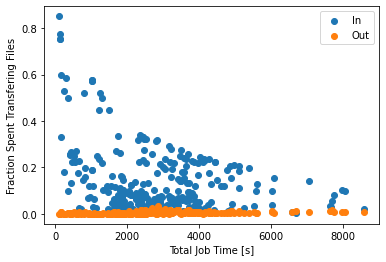

In [27]:
for direction in ['In','Out'] :
    plt.scatter(df['JobTime'],df[f'FracTransfer{direction}'], label=direction)
plt.xlabel('Total Job Time [s]')
plt.ylabel('Fraction Spent Transfering Files')
plt.legend()
plt.show()

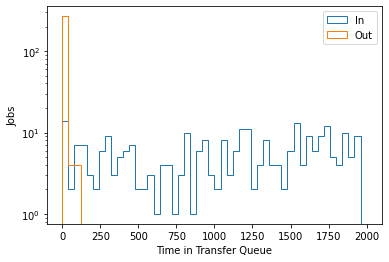

In [28]:
for direction in ['In','Out'] :
    plt.hist(df[f'Transfer{direction}QueueTime'],bins=50,range=(0,2000),label=direction,histtype='step')
plt.legend()
plt.xlabel('Time in Transfer Queue')
plt.ylabel('Jobs')
plt.yscale('log')
plt.show()